In [1]:
import pandas as pd
from googleapiclient import discovery
import time
from googleapiclient.errors import HttpError
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr

In [2]:
df = pd.read_csv('abc.csv', low_memory=False)

In [3]:
sampled_df = df.iloc[:10000].copy()

In [4]:
API_KEY = 'abc' # Your own API key

client = discovery.build(
    "commentanalyzer",
    "v1alpha1",
    developerKey=API_KEY,
    discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
    static_discovery=False,
)

In [5]:
# Send one request and get all attributes in Perspective API
attributes = ['TOXICITY', 'SEVERE_TOXICITY', 'IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'THREAT']

results = []

start_time = time.time()
max_duration = 12*3600 # Can be changed
max_retries = 10
processed_tweets = 0
save_interval = 1000  
error_save_file = 'New_1_partial_with_multiple_scores.csv'

for index, row in sampled_df.iterrows():
    if time.time() - start_time > max_duration:
        print("Time limit reached, stopping the processing...")
        break

    analyze_request = {
        'comment': {'text': row['text']},
        'requestedAttributes': {attr: {} for attr in attributes},
        'languages': ['fr']
    }

    retries = 0
    while retries < max_retries:
        try:
            response = client.comments().analyze(body=analyze_request).execute()
            result = row.to_dict()
            for attr in attributes:
                score = response['attributeScores'][attr]['summaryScore']['value']
                result[attr + '_score'] = score
            results.append(result)
            processed_tweets += 1
            time.sleep(0.1) # Sleeping time is depending on the QPS you have in your account, can contact Perspective API team to increase it
            break
        except HttpError as e:
            print(f"HTTP error for index {index}: {e}")
            if 'Quota exceeded' in str(e):
                print("Quota exceeded error, sleeping for 20 seconds...")
                time.sleep(10)
            else:
                time.sleep(5)
        except TimeoutError as e:
            retries += 1
            print(f"Timeout error for index {index}, retrying ({retries}/{max_retries})...")
            time.sleep(10)
        except Exception as e:
            print(f"Unexpected error for index {index}: {e}")
            time.sleep(5)
        continue

    if processed_tweets % save_interval == 0: #Save the results for every 1000 tweets 
        print(f"Saving progress... {processed_tweets} tweets processed.")
        pd.DataFrame(results).to_csv(error_save_file, index=False, sep=',')

pd.DataFrame(results).to_csv('New_1_all_with_multiple_scores.csv', index=False, sep=',')

print(f"Data processing complete and saved to 'New_1_all_with_multiple_scores.csv'. {processed_tweets} tweets were analyzed.")

Saving progress... 1000 tweets processed.
Saving progress... 2000 tweets processed.
Saving progress... 3000 tweets processed.
Saving progress... 4000 tweets processed.
Saving progress... 5000 tweets processed.
Saving progress... 6000 tweets processed.
Saving progress... 7000 tweets processed.
Saving progress... 8000 tweets processed.
Saving progress... 9000 tweets processed.
Saving progress... 10000 tweets processed.
Saving progress... 11000 tweets processed.
Saving progress... 12000 tweets processed.
Saving progress... 13000 tweets processed.
Saving progress... 14000 tweets processed.
Saving progress... 15000 tweets processed.
Saving progress... 16000 tweets processed.
Saving progress... 17000 tweets processed.
Saving progress... 18000 tweets processed.
Saving progress... 19000 tweets processed.
Saving progress... 20000 tweets processed.
Saving progress... 21000 tweets processed.
Saving progress... 22000 tweets processed.
Saving progress... 23000 tweets processed.
Saving progress... 2

# Merged Data

In [1]:
file_prefix = "New_"
file_suffix = "_all_with_multiple_scores.csv"
num_files = 18

merged_df = pd.DataFrame()

for i in range(1, num_files + 1):
    file_name = f"{file_prefix}{i}{file_suffix}"
    temp_df = pd.read_csv(file_name)

    if i == 1:
        merged_df = temp_df
    else:
        merged_df = pd.concat([merged_df, temp_df], ignore_index=True)

merged_df.to_csv("Merged_all_with_multiple_scores.csv", index=False)

print("Finished to process Merged_all_with_multiple_scores.csv")


C:\Users\lvshu\AppData\Local\Temp\ipykernel_16236\2714044852.py:15: DtypeWarning: Columns (29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(file_name)
C:\Users\lvshu\AppData\Local\Temp\ipykernel_16236\2714044852.py:15: DtypeWarning: Columns (29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(file_name)


文件合并完成并保存为Merged_all_with_multiple_scores.csv


# Analysis

In [2]:
df = pd.read_csv('Merged_all_with_multiple_scores.csv', low_memory=False)

In [3]:
new_df = df.copy()

In [4]:
new_df.shape

(4492190, 46)

In [5]:
new_df['pred_label'].value_counts()

non-abusive    3620007
abusive         872183
Name: pred_label, dtype: int64

In [6]:
non_abusive_df = new_df[new_df['pred_label'] == 'non-abusive'].sample(n=872183, random_state=42)
abusive_df = new_df[new_df['pred_label'] == 'abusive'].sample(frac=1, random_state=42).reset_index(drop=True)
sampled_df = pd.concat([non_abusive_df, abusive_df])
sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
sampled_df.head()

,id,timestamp_utc,local_time,user_screen_name,text,retweet_count,like_count,reply_count,to_username,to_userid,...,crit_label,crit_proba,support_label,support_proba,TOXICITY_score,SEVERE_TOXICITY_score,IDENTITY_ATTACK_score,INSULT_score,PROFANITY_score,THREAT_score
0,1639304461624410113,1679675615,2023-03-24 17:33:35,OhLoiz,@auroreberge Si je pige le propos de l' interv...,0.0,0.0,NaN,auroreberge,3.750928e+07,...,1,0.925132,0,0.961415,0.122601,0.002108,0.004680,0.116167,0.014806,0.005432
1,1602968533738061826,1671012454,2022-12-14 11:07:34,Trojasky,"@sandrousseau Bah tiens, parlons donc de ""réch...",0.0,0.0,0.0,sandrousseau,3.713811e+08,...,0,0.928905,0,0.962458,0.014074,0.000532,0.000437,0.014581,0.009699,0.005269
2,1638969177456144397,1679595677,2023-03-23 19:21:17,billet_bernard,@ECiotti La terreur c'est vous également qui l...,0.0,0.0,NaN,ECiotti,8.788675e+07,...,1,0.918617,0,0.962416,0.457030,0.031420,0.010803,0.567870,0.176599,0.028725
3,1648550883133734912,1681880133,2023-04-19 06:55:33,MICHEL_WOOD_BE,@alexiscorbiere Et oui tonton la chaudière !,0.0,0.0,NaN,alexiscorbiere,2.662153e+08,...,1,0.880668,0,0.958946,0.058490,0.002728,0.001221,0.043836,0.015147,0.006207
4,1582445673756393472,1666119423,2022-10-18 20:57:03,SldKarine,@LouisBoyard Salut bouffon .... t'as oublié ce...,0.0,0.0,0.0,LouisBoyard,9.046773e+17,...,1,0.933942,0,0.961619,0.757031,0.613830,0.382460,0.788825,0.646572,0.064969


In [8]:
sampled_df["pred_label"].replace({"non-abusive": 0, "abusive": 1}, inplace = True)

## Insult Score

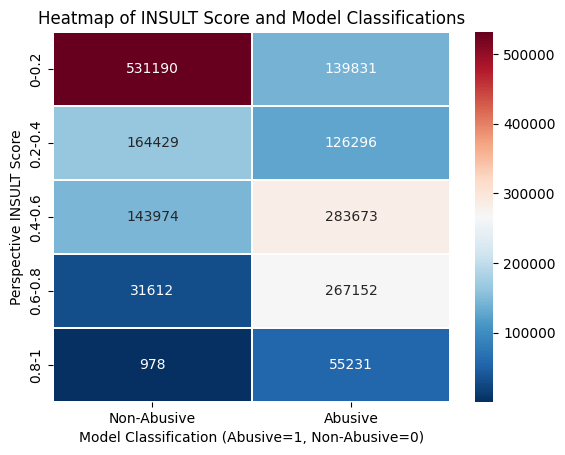

Point-biserial correlation coefficient: 0.5605821414548452
P-value: 0.0


In [9]:
score_bins = np.arange(0, 1.2, 0.2)  # 0.2 as a gap
heatmap_data, xedges, yedges = np.histogram2d(sampled_df['INSULT_score'], sampled_df['pred_label'], bins=(score_bins, [0, 0.5, 1]))

sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='RdBu_r', linewidths=0.3, xticklabels=['Non-Abusive', 'Abusive'], yticklabels=['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1'])

plt.xlabel('Model Classification (Abusive=1, Non-Abusive=0)')
plt.ylabel('Perspective INSULT Score')
plt.title('Heatmap of INSULT Score and Model Classifications')
plt.show()

corr, p_value = pointbiserialr(sampled_df['INSULT_score'], sampled_df['pred_label'])
print(f"Point-biserial correlation coefficient: {corr}")
print(f"P-value: {p_value}")

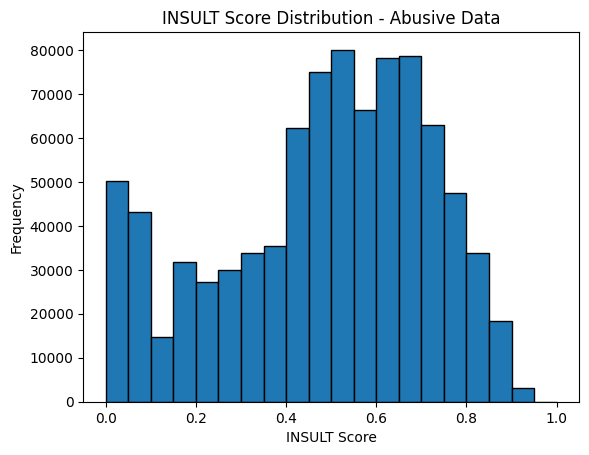

In [10]:
# Plot
bins = [i * 0.05 for i in range(21)]
plt.hist(abusive_df['INSULT_score'], bins=bins, edgecolor='black')

plt.title('INSULT Score Distribution - Abusive Data')
plt.xlabel('INSULT Score')
plt.ylabel('Frequency')

plt.show()

In [21]:
# Set a threshold
higher_score = abusive_df[abusive_df['INSULT_score'] > 0.5]
num_higher_score = len(higher_score['INSULT_score'])
num_higher_score

468794

## TOXICITY Score

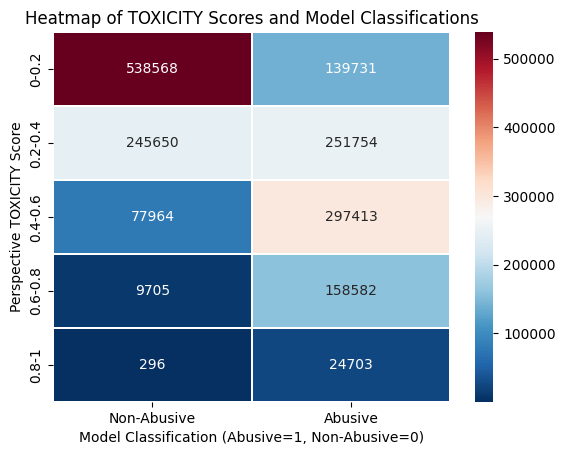

Point-biserial correlation coefficient: 0.5606540178707727
P-value: 0.0


In [11]:
score_bins = np.arange(0, 1.2, 0.2)  # 0.2 as a gap
heatmap_data, xedges, yedges = np.histogram2d(sampled_df['TOXICITY_score'], sampled_df['pred_label'], bins=(score_bins, [0, 0.5, 1]))

sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='RdBu_r', linewidths=0.3, xticklabels=['Non-Abusive', 'Abusive'], yticklabels=['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1'])

plt.xlabel('Model Classification (Abusive=1, Non-Abusive=0)')
plt.ylabel('Perspective TOXICITY Score')
plt.title('Heatmap of TOXICITY Scores and Model Classifications')
plt.show()

corr, p_value = pointbiserialr(sampled_df['TOXICITY_score'], sampled_df['pred_label'])
print(f"Point-biserial correlation coefficient: {corr}")
print(f"P-value: {p_value}")

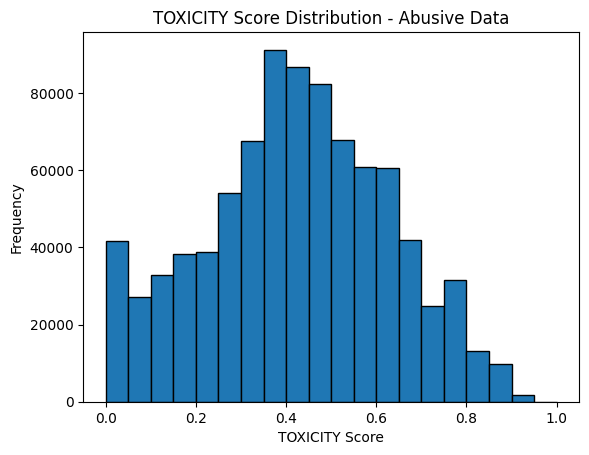

In [12]:
# Plot
bins = [i * 0.05 for i in range(21)]
plt.hist(abusive_df['TOXICITY_score'], bins=bins, edgecolor='black')

plt.title('TOXICITY Score Distribution - Abusive Data')
plt.xlabel('TOXICITY Score')
plt.ylabel('Frequency')

plt.show()

In [22]:
# Set a threshold
higher_score = abusive_df[abusive_df['TOXICITY_score'] > 0.5]
num_higher_score = len(higher_score['TOXICITY_score'])
num_higher_score

311689

## PROFANITY Score

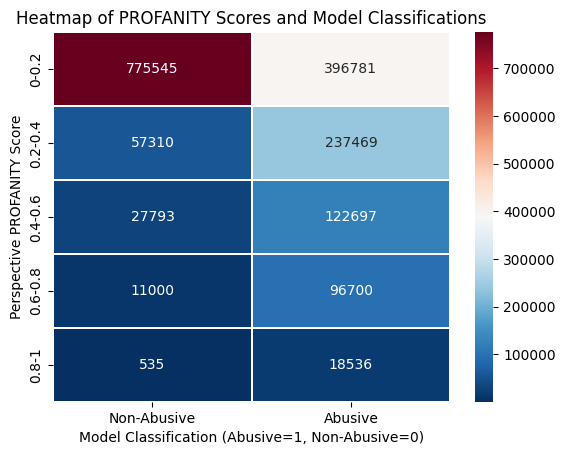

Point-biserial correlation coefficient: 0.4781436357499936
P-value: 0.0


In [13]:
score_bins = np.arange(0, 1.2, 0.2)  # 0.2 as a gap
heatmap_data, xedges, yedges = np.histogram2d(sampled_df['PROFANITY_score'], sampled_df['pred_label'], bins=(score_bins, [0, 0.5, 1]))

sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='RdBu_r', linewidths=0.3, xticklabels=['Non-Abusive', 'Abusive'], yticklabels=['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1'])

plt.xlabel('Model Classification (Abusive=1, Non-Abusive=0)')
plt.ylabel('Perspective PROFANITY Score')
plt.title('Heatmap of PROFANITY Scores and Model Classifications')
plt.show()

corr, p_value = pointbiserialr(sampled_df['PROFANITY_score'], sampled_df['pred_label'])
print(f"Point-biserial correlation coefficient: {corr}")
print(f"P-value: {p_value}")

In [23]:
# Set a threshold
higher_score = abusive_df[abusive_df['PROFANITY_score'] > 0.5]
num_higher_score = len(higher_score['PROFANITY_score'])
num_higher_score

165829

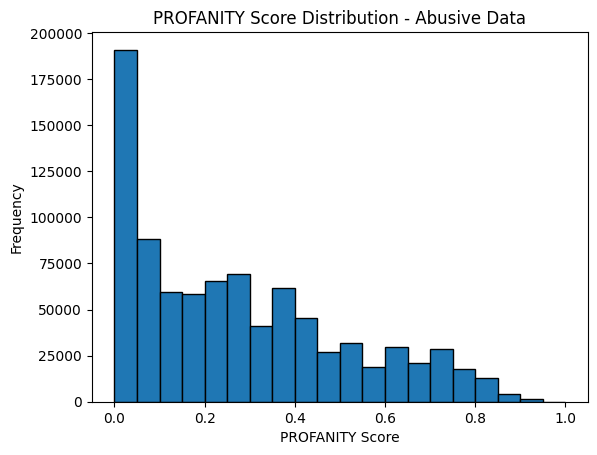

In [14]:
# Plot
bins = [i * 0.05 for i in range(21)]
plt.hist(abusive_df['PROFANITY_score'], bins=bins, edgecolor='black')

plt.title('PROFANITY Score Distribution - Abusive Data')
plt.xlabel('PROFANITY Score')
plt.ylabel('Frequency')

plt.show()

## SEVERE TOXICITY Score

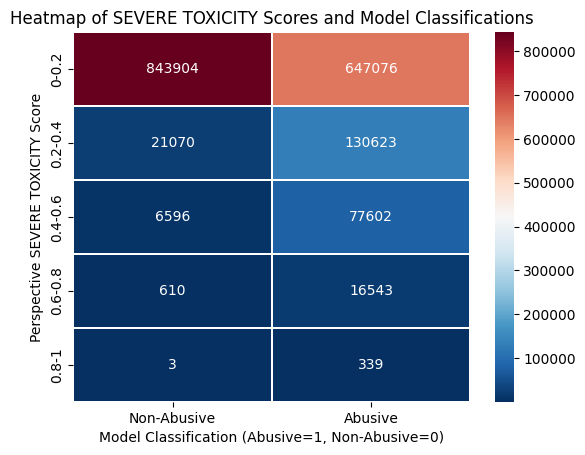

Point-biserial correlation coefficient: 0.3836317609967212
P-value: 0.0


In [15]:
score_bins = np.arange(0, 1.2, 0.2)  # 0.2 as a gap
heatmap_data, xedges, yedges = np.histogram2d(sampled_df['SEVERE_TOXICITY_score'], sampled_df['pred_label'], bins=(score_bins, [0, 0.5, 1]))

sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='RdBu_r', linewidths=0.3, xticklabels=['Non-Abusive', 'Abusive'], yticklabels=['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1'])

plt.xlabel('Model Classification (Abusive=1, Non-Abusive=0)')
plt.ylabel('Perspective SEVERE TOXICITY Score')
plt.title('Heatmap of SEVERE TOXICITY Scores and Model Classifications')
plt.show()

corr, p_value = pointbiserialr(sampled_df['SEVERE_TOXICITY_score'], sampled_df['pred_label'])
print(f"Point-biserial correlation coefficient: {corr}")
print(f"P-value: {p_value}")

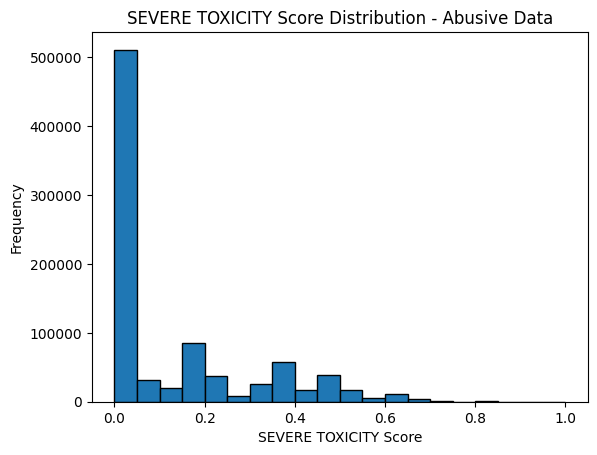

In [16]:
# Plot
bins = [i * 0.05 for i in range(21)]
plt.hist(abusive_df['SEVERE_TOXICITY_score'], bins=bins, edgecolor='black')

plt.title('SEVERE TOXICITY Score Distribution - Abusive Data')
plt.xlabel('SEVERE TOXICITY Score')
plt.ylabel('Frequency')

plt.show()

In [24]:
# Set a threshold
higher_score = abusive_df[abusive_df['SEVERE_TOXICITY_score'] > 0.5]
num_higher_score = len(higher_score['SEVERE_TOXICITY_score'])
num_higher_score

38693

## IDENTITY ATTACK Score

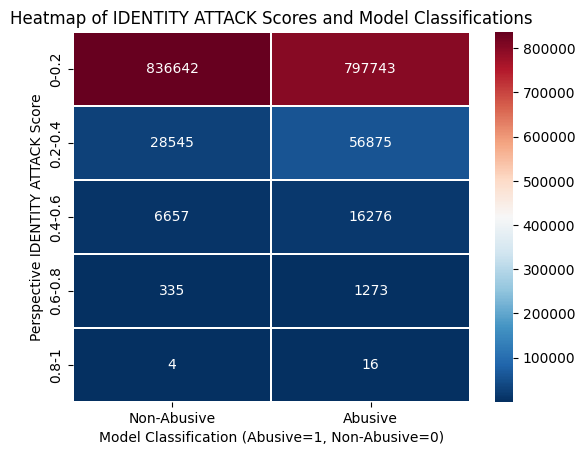

Point-biserial correlation coefficient: 0.16831734679142954
P-value: 0.0


In [17]:
score_bins = np.arange(0, 1.2, 0.2)  # 0.2 as a gap
heatmap_data, xedges, yedges = np.histogram2d(sampled_df['IDENTITY_ATTACK_score'], sampled_df['pred_label'], bins=(score_bins, [0, 0.5, 1]))

sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='RdBu_r', linewidths=0.3, xticklabels=['Non-Abusive', 'Abusive'], yticklabels=['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1'])

plt.xlabel('Model Classification (Abusive=1, Non-Abusive=0)')
plt.ylabel('Perspective IDENTITY ATTACK Score')
plt.title('Heatmap of IDENTITY ATTACK Scores and Model Classifications')
plt.show()

corr, p_value = pointbiserialr(sampled_df['IDENTITY_ATTACK_score'], sampled_df['pred_label'])
print(f"Point-biserial correlation coefficient: {corr}")
print(f"P-value: {p_value}")

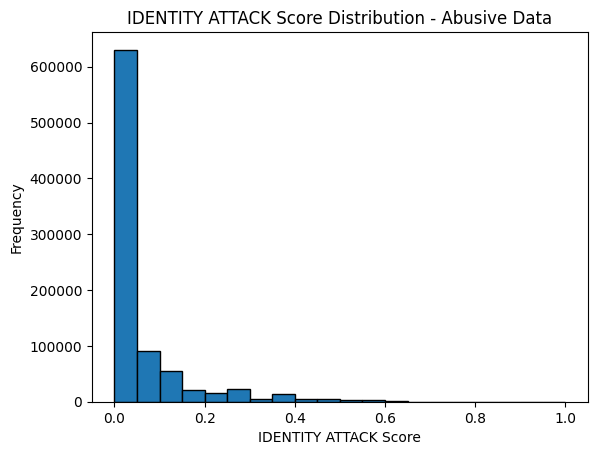

In [18]:
# Plot
bins = [i * 0.05 for i in range(21)]
plt.hist(abusive_df['IDENTITY_ATTACK_score'], bins=bins, edgecolor='black')

plt.title('IDENTITY ATTACK Score Distribution - Abusive Data')
plt.xlabel('IDENTITY ATTACK Score')
plt.ylabel('Frequency')

plt.show()

In [25]:
# Set a threshold
higher_score = abusive_df[abusive_df['IDENTITY_ATTACK_score'] > 0.5]
num_higher_score = len(higher_score['IDENTITY_ATTACK_score'])
num_higher_score

6508

## THREAT Score

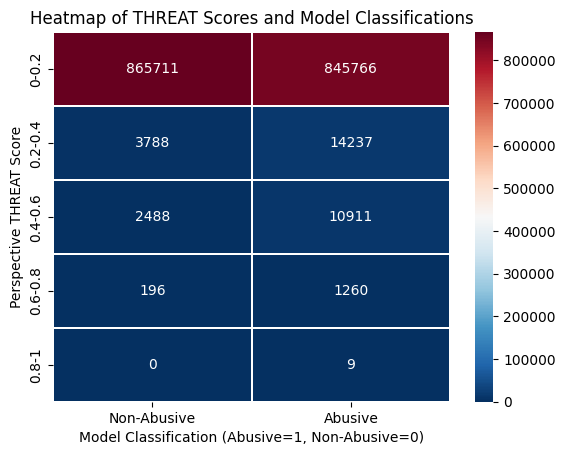

Point-biserial correlation coefficient: 0.13805519997543192
P-value: 0.0


In [19]:
score_bins = np.arange(0, 1.2, 0.2)  # 0.2 as a gap
heatmap_data, xedges, yedges = np.histogram2d(sampled_df['THREAT_score'], sampled_df['pred_label'], bins=(score_bins, [0, 0.5, 1]))

sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='RdBu_r', linewidths=0.3, xticklabels=['Non-Abusive', 'Abusive'], yticklabels=['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1'])

plt.xlabel('Model Classification (Abusive=1, Non-Abusive=0)')
plt.ylabel('Perspective THREAT Score')
plt.title('Heatmap of THREAT Scores and Model Classifications')
plt.show()

corr, p_value = pointbiserialr(sampled_df['THREAT_score'], sampled_df['pred_label'])
print(f"Point-biserial correlation coefficient: {corr}")
print(f"P-value: {p_value}")

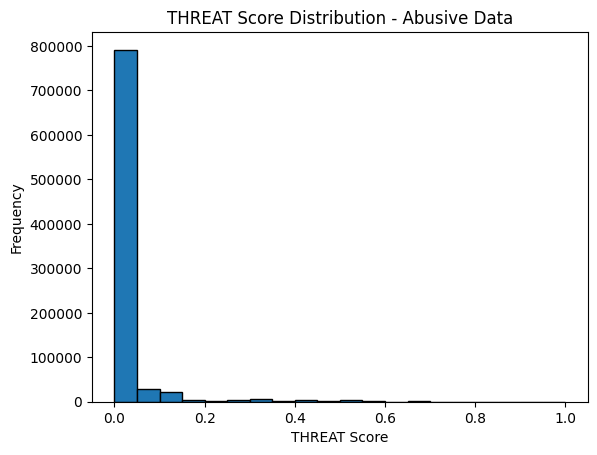

In [20]:
# Plot
bins = [i * 0.05 for i in range(21)]
plt.hist(abusive_df['THREAT_score'], bins=bins, edgecolor='black')

plt.title('THREAT Score Distribution - Abusive Data')
plt.xlabel('THREAT Score')
plt.ylabel('Frequency')

plt.show()

In [26]:
# Set a threshold
higher_score = abusive_df[abusive_df['THREAT_score'] > 0.5]
num_higher_score = len(higher_score['THREAT_score'])
num_higher_score

6614